In [21]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Dataset directories
training_dir = "data/Training"
testing_dir = "data/Testing"

# Processed data directories
processed_training_dir = "data/Processed/Training"
processed_testing_dir = "data/Processed/Testing"

# Class names
classes = ['glioma', 'meningioma', 'notumor']

In [22]:
def load_images_from_class(dataset_path, class_name, num_samples=3):
    """
    Loads up to num_samples images from the specified class folder in dataset_path.
    Returns a list of tuples: (image_file_path, image_array)
    """
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]
    image_files = image_files[:num_samples]
    images = []
    for image_file in image_files:
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is not None:
            images.append((image_file, img))
    return images


def plot_samples(dataset_path, preprocess, target_size, threshold_value):
    """
    Plots sample images
    """
    plt.style.use('default')
    fig, axs = plt.subplots(len(classes), 3, figsize=(6, 6))
    for i, class_name in enumerate(classes):
        images = load_images_from_class(dataset_path, class_name, num_samples=3)
        for j, (img_path, img) in enumerate(images):
            if preprocess:
                img = crop_and_resize(img, target_size=target_size, threshold_value=threshold_value)
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f"{class_name}\n{os.path.basename(img_path)}\nSize: {img.shape}")
    plt.tight_layout()
    plt.show()


def get_image_size_statistics(dataset_path):
    """
    Computes and prints average dimensions for each class in the specified dataset_path.
    """
    for class_name in classes:
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sizes = []
        for image_file in image_files:
            img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                sizes.append(img.shape)
        if sizes:
            sizes = np.array(sizes)
            avg_height = np.mean(sizes[:, 0])
            avg_width = np.mean(sizes[:, 1])
            print(f"Class '{class_name}': {len(sizes)} images, Average Size: {avg_height:.2f} x {avg_width:.2f}")
        else:
            print(f"Class '{class_name}': No images found.")


def crop_and_resize(img, target_size, threshold_value):
    """
    Dynamically crops the image by removing excess background based on a threshold and resizes the image.
    """
    # Threshold the image to create a binary mask.
    # Pixels above threshold_value become white (foreground); below become black (background).
    _, thresh = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY)

    # Find the coordinates of all non-zero pixels.
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        # Get the bounding box of the non-zero pixels.
        x, y, w, h = cv2.boundingRect(coords)
        # Crop the image to this bounding box.
        cropped = img[y: y + h, x: x + w]
        return cv2.resize(cropped, target_size)
    else:
        # If no foreground was found, just return the original image.
        return cv2.resize(img, target_size)


Original Training Data Statistics:

Class 'glioma': 1321 images, Average Size: 512.00 x 512.00
Class 'meningioma': 1339 images, Average Size: 495.23 x 493.39
Class 'notumor': 1595 images, Average Size: 320.73 x 313.95

Original Training Data Samples:



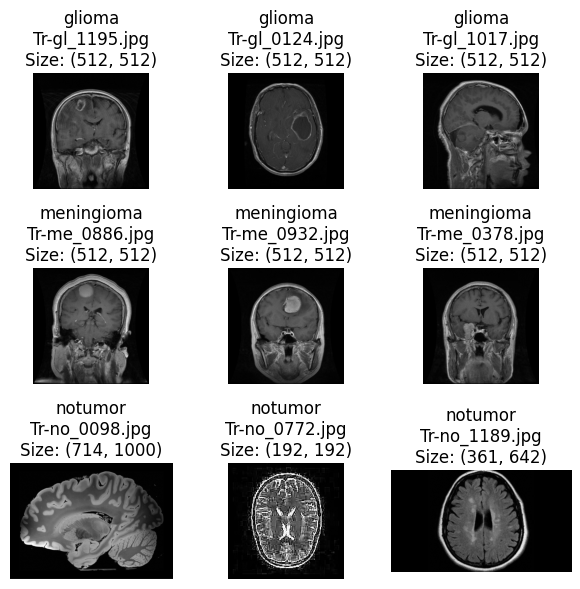


Cropped and resized data samples:



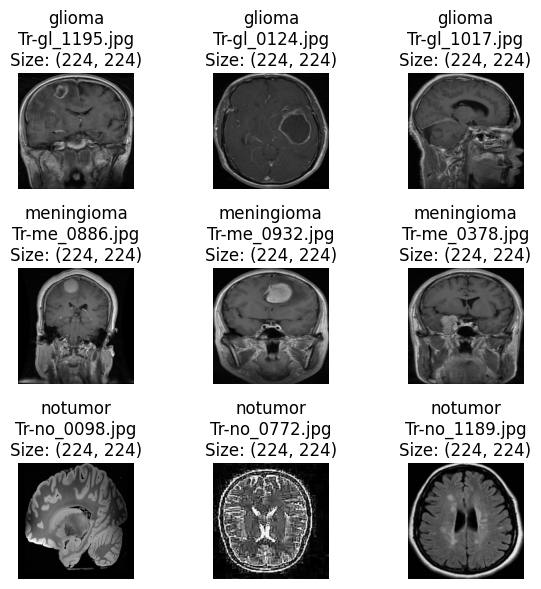

In [23]:
# Visualizing original training data
print("\nOriginal Training Data Statistics:\n")
get_image_size_statistics(training_dir)
print("\nOriginal Training Data Samples:\n")
plot_samples(training_dir, False, None, None)

# Visualize cropped and resized data
print("\nCropped and resized data samples:\n")
plot_samples(training_dir, True, (224,224), 50)